<a href="https://colab.research.google.com/github/Edison299792458/-/blob/main/Untitled8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd           
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time

plt.style.use('ggplot')

In [ ]:
from google.colab import drive                                          
import pandas as pd
drive.mount('/content/gdrive') # 此處需要登入google帳號
# 獲取授權碼之後輸入即可連動雲端硬碟
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/TWF_Futures_Minute_Trade.txt")
df

Mounted at /content/gdrive


,Date,Time,Open,High,Low,Close,TotalVolume
0,2009/1/5,08:46:00,4722.0,4745.0,4714.0,4727.0,1493
1,2009/1/5,08:47:00,4727.0,4728.0,4711.0,4716.0,608
2,2009/1/5,08:48:00,4713.0,4720.0,4713.0,4716.0,400
3,2009/1/5,08:49:00,4717.0,4722.0,4715.0,4718.0,457
4,2009/1/5,08:50:00,4719.0,4721.0,4718.0,4719.0,233
...,...,...,...,...,...,...,...
1971251,2022/5/23,09:10:00,16210.0,16216.0,16206.0,16214.0,452
1971252,2022/5/23,09:11:00,16215.0,16215.0,16207.0,16210.0,224
1971253,2022/5/23,09:12:00,16210.0,16220.0,16207.0,16218.0,478
1971254,2022/5/23,09:13:00,16218.0,16220.0,16212.0,16218.0,240


In [ ]:
df.index = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.drop(columns=['Date','Time'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['Hour'] = df.index.map(lambda x: x.hour)
df.head(3)

,open,high,low,close,volume,Hour
2009-01-05 08:46:00,4722.0,4745.0,4714.0,4727.0,1493,8
2009-01-05 08:47:00,4727.0,4728.0,4711.0,4716.0,608,8
2009-01-05 08:48:00,4713.0,4720.0,4713.0,4716.0,400,8


In [ ]:
rule = '60T'

Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
Morning.index = Morning.index + dt.timedelta(minutes=15)

d1 = Morning.resample(rule=rule, closed='right', label='left').first()[['open']]
d2 = Morning.resample(rule=rule, closed='right', label='left').max()[['high']]
d3 = Morning.resample(rule=rule, closed='right', label='left').min()[['low']]
d4 = Morning.resample(rule=rule, closed='right', label='left').last()[['close']]
d5 = Morning.resample(rule=rule, closed='right', label='left').sum()[['volume']]

df_Morning = pd.concat([d1,d2,d3,d4,d5], axis=1)
df_Morning = df_Morning.dropna()
df_Morning.index = df_Morning.index - dt.timedelta(minutes=15)
df_Morning.head()

,open,high,low,close,volume
2009-01-05 08:45:00,4722.0,4797.0,4692.0,4758.0,27508
2009-01-05 09:45:00,4759.0,4767.0,4710.0,4732.0,15701
2009-01-05 10:45:00,4732.0,4733.0,4634.0,4670.0,25172
2009-01-05 11:45:00,4672.0,4688.0,4636.0,4680.0,13241
2009-01-05 12:45:00,4680.0,4698.0,4656.0,4670.0,16247


In [ ]:
df_Morning['Hour'] = df_Morning.index.map(lambda x: x.hour)

In [ ]:
testData = df_Morning[(df_Morning.index >= '2011-01-01 00:00:00') & (df_Morning.index <= '2019-12-31 00:00:00')].copy()
trainData = df_Morning[(df_Morning.index >= '2020-1-1 00:00:00') & (df_Morning.index <= '2022-5-22 00:00:00')].copy()

In [ ]:
fund = 1000000
feePaid = 600
length = 3
NumStd = 1.5
K = 0.04

# trainData['H'] = trainData['high'].shift(1).rolling(window=length, center=False).max()
# trainData['L'] = trainData['low'].shift(1).rolling(window=length, center=False).min()
trainData['MA'] = trainData['close'].rolling(window=3, center=False).mean()
trainData['nSTD'] = trainData['close'].rolling(window=12, center=False).std()
trainData['STD']=(trainData['nSTD']/trainData['MA'])
trainData['MA200'] = trainData['close'].rolling(window=30, center=False).mean()
trainData['upLine'] = trainData['MA200'] + NumStd*trainData['nSTD']
trainData['downLine'] = trainData['MA200'] - NumStd*trainData['nSTD']
trainData['MA200'] = trainData['close'].rolling(window=30, center=False).mean()
trainData.tail(3)

trainData['MA15'] = trainData['close'].rolling(window=15, center=False).mean()

trainData['MA180'] = trainData['close'].rolling(window=30, center=False).mean()
trainData['nSTD180'] = trainData['MA180'].rolling(window=3, center=False).mean()
trainData['sb']=trainData['nSTD180']-trainData['MA180']
trainData['STD180']=(trainData['nSTD180']/trainData['MA180'])
trainData.tail(3)

,open,high,low,close,volume,Hour,MA,nSTD,STD,MA200,upLine,downLine,MA15,MA180,nSTD180,sb,STD180
2022-05-20 10:45:00,16104.0,16140.0,16104.0,16134.0,12993,10,16110.333333,166.681219,0.010346,15979.533333,16229.555162,15729.511505,16077.2,15979.533333,15968.566667,-10.966667,0.999314
2022-05-20 11:45:00,16134.0,16140.0,16113.0,16128.0,7654,11,16122.333333,161.033499,0.009988,15994.133333,16235.683582,15752.583084,16080.0,15994.133333,15980.455556,-13.677778,0.999145
2022-05-20 12:45:00,16129.0,16145.0,16110.0,16135.0,12758,12,16132.333333,152.977915,0.009483,16010.900000,16240.366872,15781.433128,16084.0,16010.900000,15994.855556,-16.044444,0.998998


In [ ]:
test= np.array(trainData['MA200'])
difftest=np.diff(test,n=2)
difftest=np.insert(difftest,0,[None,None])
trainData['diff']=difftest

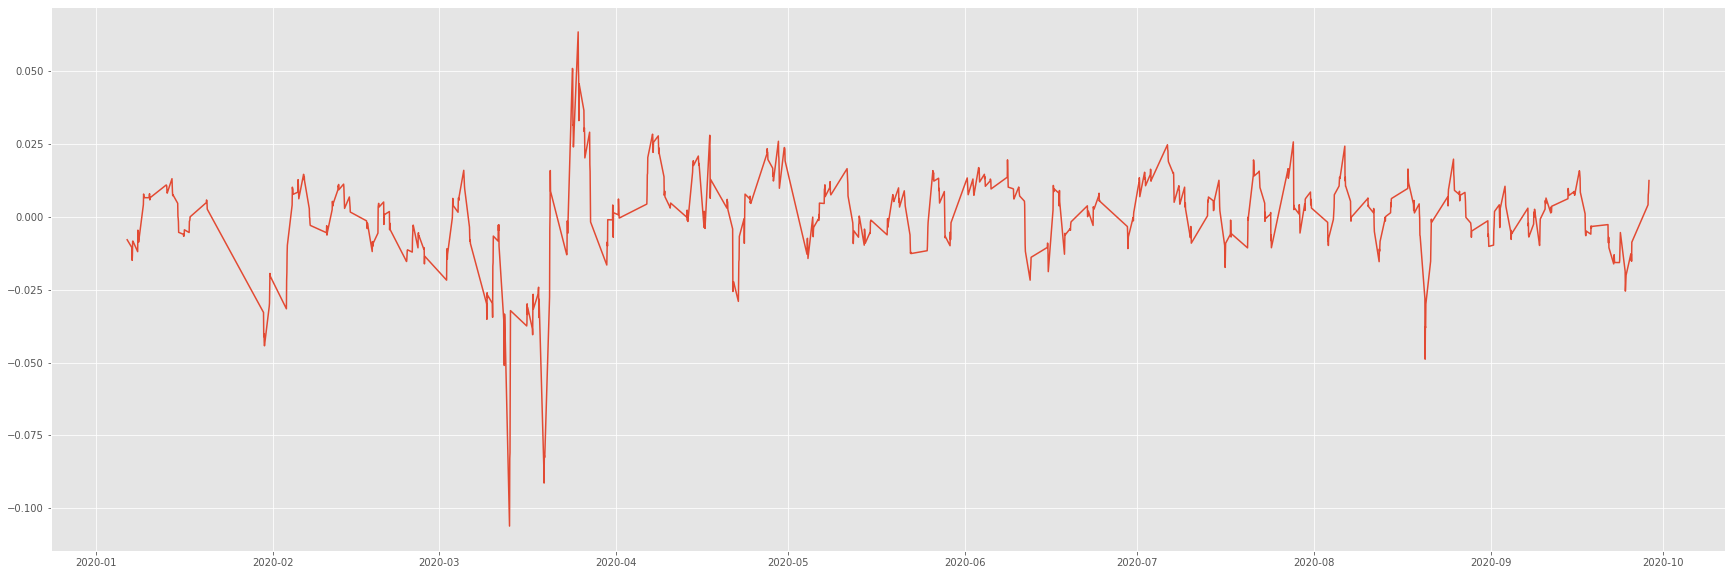

<Figure size 432x288 with 0 Axes>

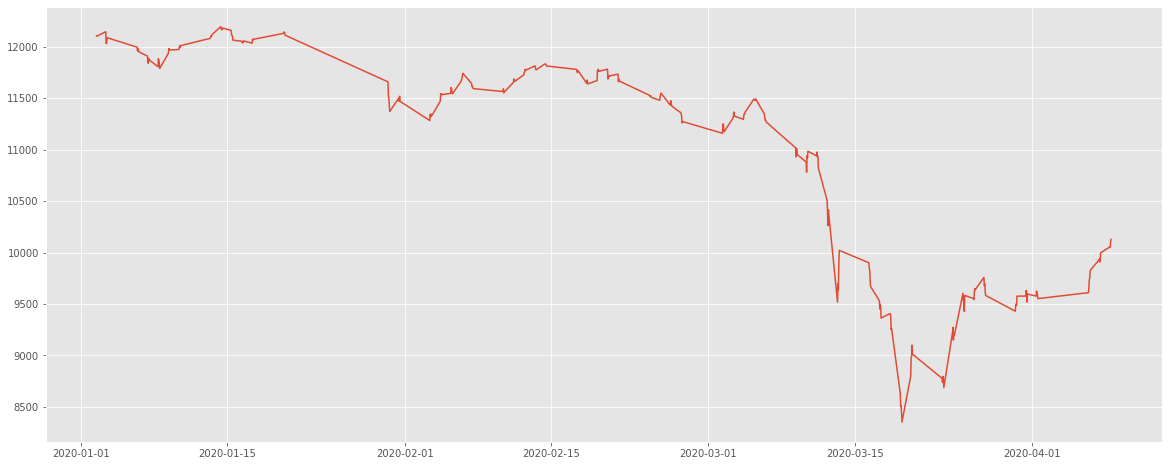

In [ ]:
trainData['nor']= ((trainData['close']-trainData['MA15'])/trainData['MA15'])
plt.figure(figsize = (30,10))
plt.plot(trainData['nor'][3:900])
plt.figure()
plt.figure(figsize = (20,8))
plt.plot(trainData['close'][3:300])
plt.show()

In [ ]:
settlementDate_= pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/結算日/settlementDate.txt")


settlementDate_.columns = ['settlementDate', 'futures', 'settlementPrice']
settlementDate_

,settlementDate,futures,settlementPrice
0,2022/08/03,202208W1,14707
1,2022/07/27,202207W4,14887
2,2022/07/20,202207,14713
3,2022/07/13,202207W2,14384
4,2022/07/06,202207W1,14015
...,...,...,...
508,2009/12/16,200912,7752
509,2009/11/18,200911,7786
510,2009/10/21,200910,7705
511,2009/09/16,200909,7445


In [ ]:
bool_ = [False if 'W' in i else True for i in settlementDate_['futures']]
bool_

[False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False

In [ ]:
settlementDate = [i.replace('/','-') for i in list(settlementDate_[bool_]['settlementDate'])]

In [ ]:
df_arr = np.array(trainData)
time_arr = np.array(trainData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]
BS = None

In [ ]:
trainData

,open,high,low,close,volume,Hour,MA,nSTD,STD,MA200,upLine,downLine,MA15,MA180,nSTD180,sb,STD180,diff,nor
2020-01-02 08:45:00,12044.0,12073.0,12023.0,12047.0,40864,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:45:00,12047.0,12104.0,12046.0,12095.0,27791,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 10:45:00,12095.0,12115.0,12089.0,12112.0,10996,10,12084.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 11:45:00,12112.0,12120.0,12105.0,12105.0,5746,11,12104.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 12:45:00,12105.0,12113.0,12096.0,12102.0,15002,12,12106.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-20 08:45:00,16069.0,16110.0,16013.0,16092.0,32305,8,15974.666667,167.961824,0.010514,15958.466667,16210.409402,15706.523931,16068.600000,15958.466667,15954.033333,-4.433333,0.999722,11.600000,0.001456
2022-05-20 09:45:00,16091.0,16124.0,16062.0,16105.0,19768,9,16036.000000,168.275455,0.010494,15967.700000,16220.113183,15715.286817,16073.666667,15967.700000,15958.777778,-8.922222,0.999441,0.933333,0.001949
2022-05-20 10:45:00,16104.0,16140.0,16104.0,16134.0,12993,10,16110.333333,166.681219,0.010346,15979.533333,16229.555162,15729.511505,16077.200000,15979.533333,15968.566667,-10.966667,0.999314,2.600000,0.003533
2022-05-20 11:45:00,16134.0,16140.0,16113.0,16128.0,7654,11,16122.333333,161.033499,0.009988,15994.133333,16235.683582,15752.583084,16080.000000,15994.133333,15980.455556,-13.677778,0.999145,2.766667,0.002985


                        profit  profitfee
2020-01-02 08:45:00        0.0        0.0
2020-01-02 09:45:00        0.0        0.0
2020-01-02 10:45:00        0.0        0.0
2020-01-02 11:45:00        0.0        0.0
2020-01-02 12:45:00        0.0        0.0
...                        ...        ...
2022-05-20 08:45:00  3788400.0  3396000.0
2022-05-20 09:45:00  3788400.0  3396000.0
2022-05-20 10:45:00  3788400.0  3396000.0
2022-05-20 11:45:00  3788400.0  3396000.0
2022-05-20 12:45:00  3788400.0  3396000.0

[2890 rows x 2 columns]
109


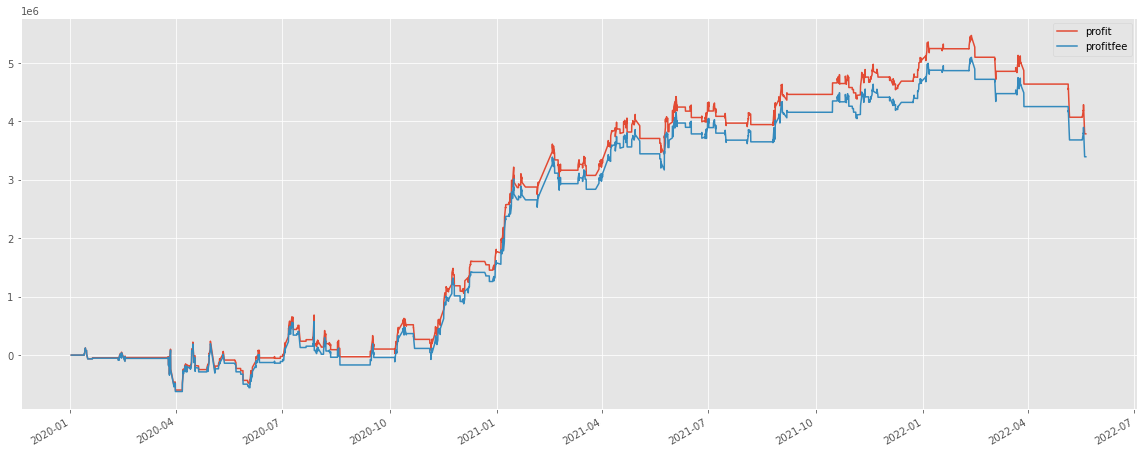

In [ ]:
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
K=0.03
entrySellShort= None
for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break
        
    ## 進場邏輯
    entryLong = df_arr[i,3] > df_arr[i,10] and df_arr[i,-4] < 0 and df_arr[i,-1] > 0.0001*28


    #entrySellShort =  df_arr[i,-4] > 0 and df_arr[i,-1] < -0.03 and df_arr[i,-4] > 0


    #df_arr[i,3] < df_arr[i,11]





    entryCondition = date_arr[i] not in settlementDate
    
    ## 出場邏輯
    exitShort = df_arr[i,3] <= df_arr[i,10]
    exitBuyToCover = df_arr[i,3] >= df_arr[i,11]
    exitCondition = date_arr[i] in settlementDate 
    
    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)

        elif entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            
    elif BS == 'B':
        profit = 2*600 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)
            
        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 600 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*6
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*6
            profit_fee_list_realized.append(profit_fee_realized)
             
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
    elif BS == 'S': 
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)
        
        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
 
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
            
equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
print(equity)
print(len(buy))
equity.plot(grid=True, figsize=(20,8));

In [ ]:
nequity=equity

In [ ]:
nequity['equity'] = nequity['profitfee'] + fund
nequity['drawdown_percent'] = (nequity['equity'] / nequity['equity'].cummax()) - 1
nequity['drawdown'] = nequity['equity'] - nequity['equity'].cummax()

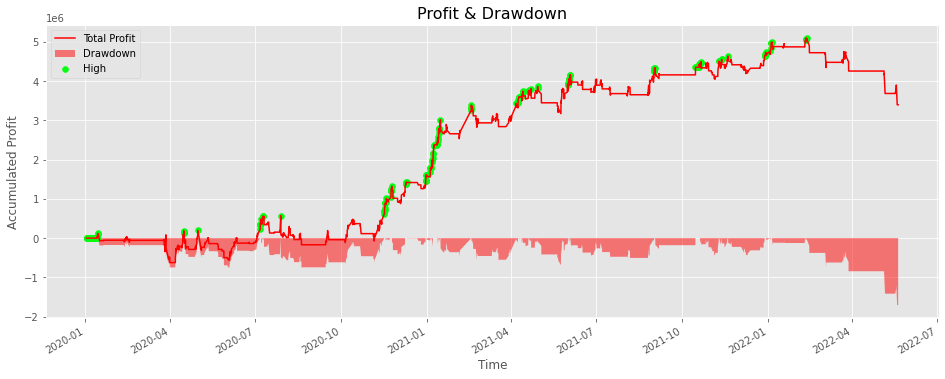

In [ ]:
fig, ax = plt.subplots(figsize = (16,6))

high_index = nequity[nequity['profitfee'].cummax() == nequity['profitfee']].index
nequity['profitfee'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
plt.fill_between(nequity['drawdown'].index, nequity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
plt.scatter(high_index, nequity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown',fontsize  = 16);


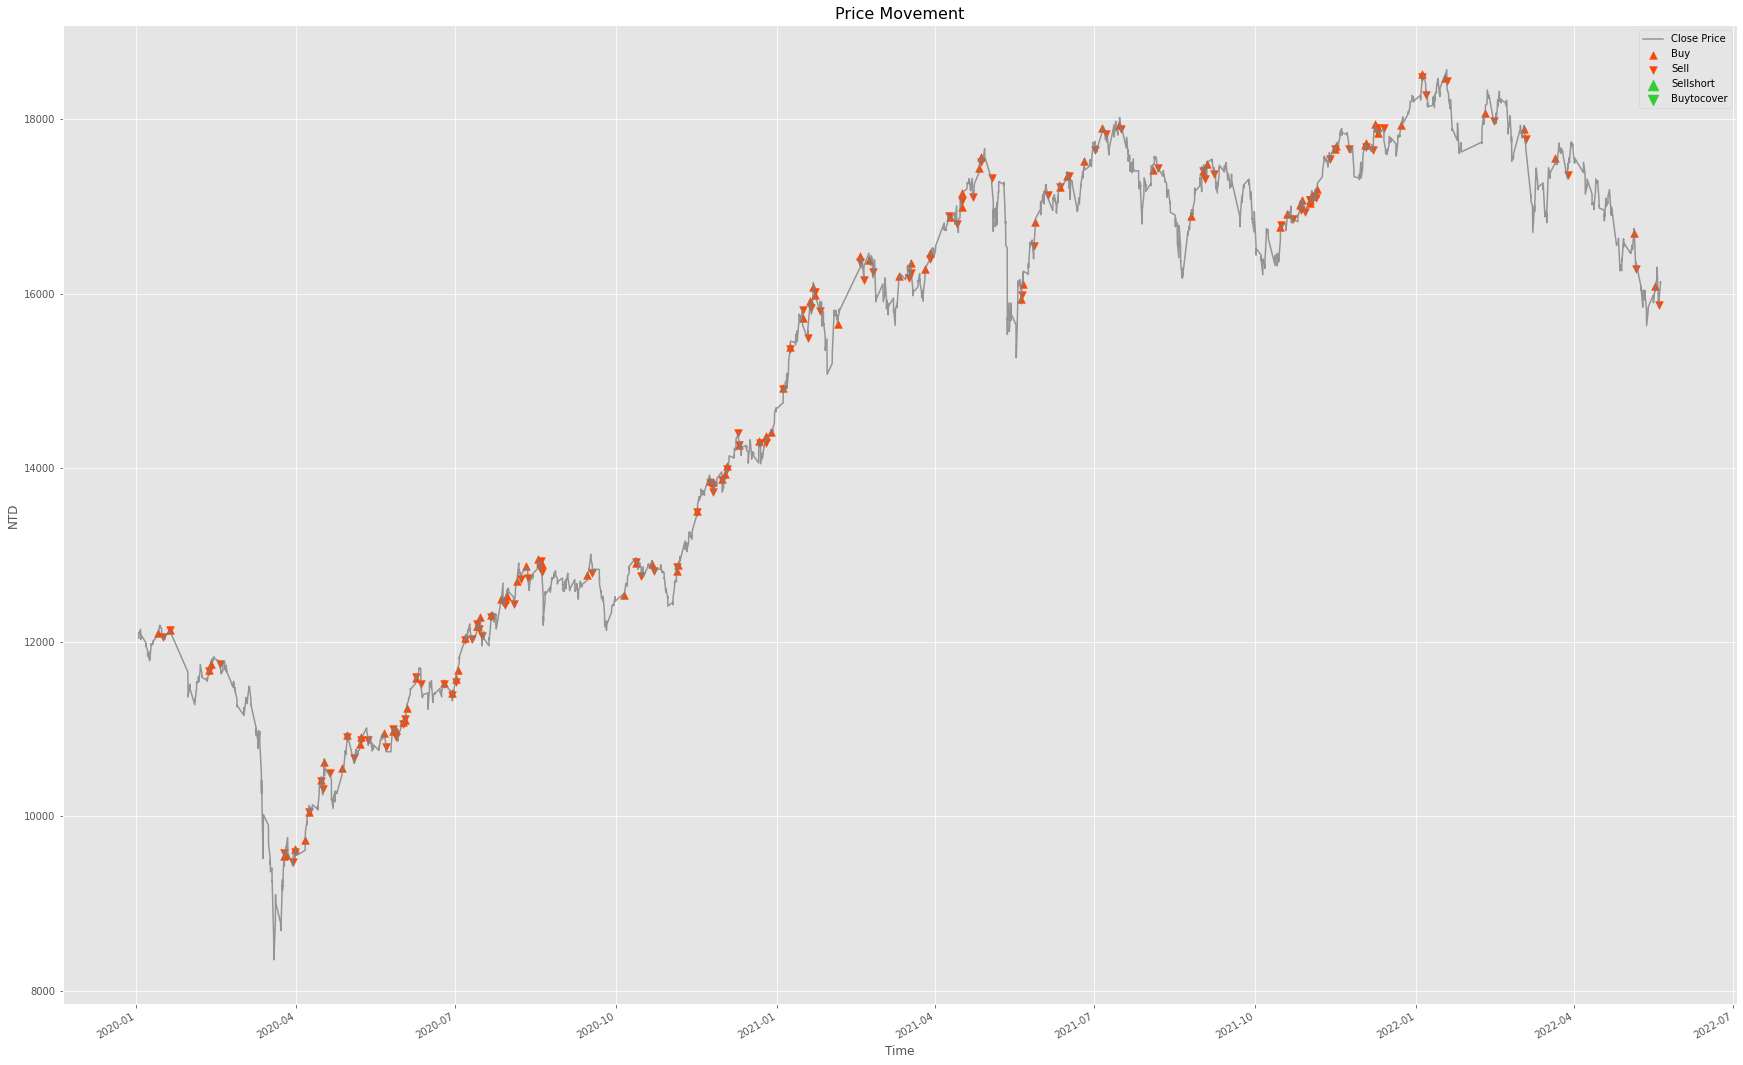

In [ ]:
fig, ax = plt.subplots(figsize = (30,20))

trainData['close'].plot(label = 'Close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
plt.scatter(trainData['close'].iloc[buy].index, trainData['close'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
plt.scatter(trainData['close'].iloc[sell].index, trainData['close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
plt.scatter(trainData['close'].iloc[sellshort].index, trainData['close'].iloc[sellshort],c = 'limegreen', label = 'Sellshort', marker='^', s=120)
plt.scatter(trainData['close'].iloc[buytocover].index, trainData['close'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='v', s=120)

plt.legend()
plt.ylabel('NTD')
plt.xlabel('Time')
plt.title('Price Movement',fontsize  = 16);

In [ ]:
nprofit_fee_list_realized = profit_fee_list_realized

In [ ]:
profit = nequity['profitfee'].iloc[-1]
ret = nequity['equity'][-1]/nequity['equity'][0] - 1
mdd = abs(nequity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy)+len(sellshort)
winRate = len([i for i in nprofit_fee_list_realized if i > 0]) / len(nprofit_fee_list_realized)
profitFactor = sum([i for i in nprofit_fee_list_realized if i > 0]) / abs(sum([i for i in nprofit_fee_list_realized if i < 0]))
winLossRatio = np.mean([i for i in nprofit_fee_list_realized if i > 0]) / abs(np.mean([i for i in nprofit_fee_list_realized if i < 0]))

print(f'profit: ${np.round(profit,2)}')
print(f'return: {np.round(ret,4)*100}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')

profit: $3396000.0
return: 339.59999999999997%
mdd: 66.5%
calmarRatio: 5.11
tradeTimes: 109
winRate: 42.199999999999996%
profitFactor: 1.39
winLossRatio: 1.9
